In [1]:
import sys, os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(os.path.join('..', '..'))
from scripts.ipa_transcription.wav2vec2_streaming import stream_cnn_chunked_transformer, stream_multi_chunked, stream_naive_chunked, stream_naive, transcribe
from scripts.ipa_transcription.wav2vec2 import load_model
from scripts.eval.streaming import run_array_source
from scripts.eval.metrics import fer, per

from scripts.data_loaders.TIMIT import TIMITDataset

In [2]:
model, processor = load_model(model_id="KoelLabs/xlsr-english-01")

### Evaluating Streaming on TIMIT
We will use TIMIT to test the latency and accuracy of streaming for various streaming methods of the wav2vec2 architecture with our XLSR English 01 model

In [3]:
dataset = TIMITDataset(split="test")

In [4]:
methods = [stream_cnn_chunked_transformer, stream_naive_chunked, stream_naive, stream_multi_chunked]
COLORS = ['orange', 'green', 'red', 'blue']

In [5]:
# create results file with columns
RESULT_CSV = os.path.join("..", "..", ".data", "scores_ipa_streaming.csv")
columns = [
    "groundtruth", 
    "non_streaming_transcript", 
    "non_streaming_fer", 
    "non_streaming_per",
    "non_streaming_time",
] + [
    f"{method}_transcript" for method in [f.__name__ for f in methods]
] + [
    f"{method}_fer" for method in [f.__name__ for f in methods]
] + [
    f"{method}_per" for method in [f.__name__ for f in methods]
] + [
    f"{method}_audio_duration" for method in [f.__name__ for f in methods]
] + [
    f"{method}_stream_duration" for method in [f.__name__ for f in methods]
] + [
    f"{method}_computation_time" for method in [f.__name__ for f in methods]
] + [
    f"{method}_warmup_latency" for method in [f.__name__ for f in methods]
] + [
    f"{method}_average_first_guess_latency" for method in [f.__name__ for f in methods]
] + [
    f"{method}_average_final_guess_latency" for method in [f.__name__ for f in methods]
] + [
    f"{method}_overall_time" for method in [f.__name__ for f in methods]
] + [
]
if os.path.exists(RESULT_CSV):
    results = pd.read_csv(RESULT_CSV)
    for col in columns:
        if col not in results.columns:
            results[col] = np.nan
    results = results[columns]
else:
    results = pd.DataFrame(columns=columns)
results.head()

,groundtruth,non_streaming_transcript,non_streaming_fer,non_streaming_per,non_streaming_time,stream_cnn_chunked_transformer_transcript,stream_naive_chunked_transcript,stream_naive_transcript,stream_multi_chunked_transcript,stream_cnn_chunked_transformer_fer,...,stream_naive_average_first_guess_latency,stream_multi_chunked_average_first_guess_latency,stream_cnn_chunked_transformer_average_final_guess_latency,stream_naive_chunked_average_final_guess_latency,stream_naive_average_final_guess_latency,stream_multi_chunked_average_final_guess_latency,stream_cnn_chunked_transformer_overall_time,stream_naive_chunked_overall_time,stream_naive_overall_time,stream_multi_chunked_overall_time
0,ʃiɦædjɝdɑɹksuɾɪŋɡɹisiwɑʃwɑɾɝʔɔljiɚ,ʃiɦædjɝdɑɹksʉɾɪnɡɹisiwɑʃwɔɾɝʔɔljɪɚ,0.008367,0.117647,0.502455,ʃiɦædjɝdɑɹksʉɾɪnɡɹisiwɑʃwɔɾɝʔɔljɪɚ,ʃiɦaʊdɚdɑɝkssʉdnɡɹsiwɑʃwwɔɾɝɚʔoʊəjieɪɹ,ʃiɦædjɝdɑɹksʉɾɪnɡɹisiwɑʃwɔɾɝʔɔljɪɚ,ʃiɦædjɝdɑɹksʉɾɪnɡɹisiwɑʃwɔɾɝʔɔljɪɚ,0.000000,...,0.125648,0.062707,0.147127,0.189977,0.245385,0.266373,2.796357,0.243034,2.998118,0.560338
1,doʊnæsmitɨkɛɹiɨnɔɪliɹæɡlaɪkðæt,doʊnæskmitɨkæɹiɨnɔɪliɹæɡlaɪkðæt,0.017798,0.064516,0.287934,doʊntæskmitɨkæɹiɪnɔɪliɹæɡlaɪkðæt,doʊntææskmidɪkæɹɹiɨnɔɪlliɹææɡaɪklæpt,doʊnæskmitɨkæɹiɨnɔɪliɹæɡlaɪkðæt,doʊnæskmitɨkæɹiɨnɔɪliɹæɡlaɪkðæt,0.017241,...,0.068102,0.064590,0.131729,0.188470,0.130835,0.226601,2.326892,0.196673,2.400747,0.477047
2,hɪzkæptɨnwəsθɪnænɦæɡɝdɨnɪzbjʉɾʉfl̩butswɚwɔɹnɨn...,hɪzkæptɪnwəsθɪnənɦæɡɝdɛnɨzbjʉɾɨfl̩butswɚwɔɹnɨn...,0.016903,0.117647,0.255505,hɪzkæptɪnwəsθɪnʌnɦæɡɝdɛnɪzbjʉɾɨfl̩butswɚwɔɹnɪn...,hɪzkæpdʌnʊsinəɦæɛɡɝdʌnʉɨspiʉɾəfoʊlbuutɔɹwɔɹmɪn...,hɪzkæptɪnwəsθɪnənɦæɡɝdɛnɨzbjʉɾɨfl̩butswɚwɔɹnɨn...,hɪzkæptɪnwəsθɪnənɦæɡɝdɛnɨzbjʉɾɨfl̩butswɚwɔɹnɨn...,0.002366,...,0.118301,0.073425,0.321731,0.184747,0.283715,0.331187,3.944877,0.336044,3.950835,0.756512
3,ðɨɹizənzfɚðɪsdaɪvsimdfulɨʃnaʊ,ðəɹizəzfɚðɨsdaɪvsimdfulɪʃnaʊ,0.023399,0.142857,0.152377,ðəɹizəzfɝðɪstaɪvsimdfulɪʃnaʊ,ðəɹiʉzəŋsfɝðɪstɑaɪsioʊmtfulʊʃbaʊl,ðəɹizəzfɚðɨsdaɪvsimdfulɪʃnaʊ,ðəɹizəzfɚðɨsdaɪvsimdfulɪʃnaʊ,0.002463,...,0.062292,0.057477,0.119056,0.177578,0.233497,0.365342,2.485066,0.213081,2.464903,0.490925
4,pɚdʌkʃɨnmeɪfɔlfɑɹbəloʊəkspɨkteɪʃn̩ts,pɹɚdʌkʃn̩meɪfɔlfɑɹbl̩loʊɛkspɛkteɪʃɨns,0.056850,0.270270,0.197161,pɹʌdʌkʃɨmeɪfɔlfɑɹbl̩loʊɛkspɛkteɪʃɨns,pɚdʌkʃɨmeɪfoʊl̩fɑɑɹbloʊwɛksbʊkteɪʃʌns,pɹɚdʌkʃn̩meɪfɔlfɑɹbl̩loʊɛkspɛkteɪʃɨns,pɹɚdʌkʃn̩meɪfɔlfɑɹbl̩loʊɛkspɛkteɪʃɨns,0.024425,...,0.062617,0.056336,0.249622,0.192371,0.217380,0.249377,2.570804,0.225040,2.566684,0.513450


In [6]:
LIMIT = 20
TRIALS = 3
for idx, sample in enumerate(dataset[:LIMIT]): # type: ignore
    ground_truth, audio = sample # type: ignore
    start = time.perf_counter()
    non_streaming_transcript = "".join(p for (p, _, _) in transcribe(audio, processor, model))
    non_streaming_time = time.perf_counter() - start
    non_streaming_fer = fer(ground_truth, non_streaming_transcript)
    non_streaming_per = per(ground_truth, non_streaming_transcript)
    row_data = {
        "groundtruth": ground_truth,
        "non_streaming_transcript": non_streaming_transcript,
        "non_streaming_fer": non_streaming_fer,
        "non_streaming_per": non_streaming_per,
        "non_streaming_time": non_streaming_time,
    }
    # --- remaining streaming methods ---
    for method in methods:
        per_trial_audio_duration = []
        per_trial_overall_time = []
        per_trial_stream_duration = []
        per_trial_computation_time = []
        per_trial_warmup_latency = []
        per_trial_average_first_guess_latency = []
        per_trial_average_final_guess_latency = []
        per_trial_per_score = []
        per_trial_fer_score = []
        final_transcript = None
        for _ in range(TRIALS):
            ws = run_array_source(audio)
            start = time.perf_counter()
            for _ in method(ws, processor=processor, model=model):
                pass
            overall_time = time.perf_counter() - start
            (
                audio_duration,
                stream_duration,
                computation_time,
                warmup_latency,
                average_first_guess_latency,
                average_final_guess_latency,
            ) = ws.evaluate()
            final_transcript = "".join(phoneme for phoneme, _, _ in ws.get_final_transcript())
            fer_score = fer(non_streaming_transcript, final_transcript)
            per_score = per(non_streaming_transcript, final_transcript)
            per_trial_audio_duration.append(audio_duration)
            per_trial_overall_time.append(overall_time)
            per_trial_stream_duration.append(stream_duration)
            per_trial_computation_time.append(computation_time)
            per_trial_warmup_latency.append(warmup_latency)
            per_trial_average_first_guess_latency.append(average_first_guess_latency)
            per_trial_average_final_guess_latency.append(average_final_guess_latency)
            per_trial_per_score.append(per_score)
            per_trial_fer_score.append(fer_score)

        row_data.update({
            f"{method.__name__}_transcript": final_transcript,
            f"{method.__name__}_fer": np.median(per_trial_fer_score),
            f"{method.__name__}_per": np.median(per_trial_per_score),
            f"{method.__name__}_audio_duration": np.median(per_trial_audio_duration),
            f"{method.__name__}_stream_duration": np.median(per_trial_stream_duration),
            f"{method.__name__}_computation_time": np.median(per_trial_computation_time),
            f"{method.__name__}_warmup_latency": np.median(per_trial_warmup_latency),
            f"{method.__name__}_average_first_guess_latency": np.median(per_trial_average_first_guess_latency),
            f"{method.__name__}_average_final_guess_latency": np.median(per_trial_average_final_guess_latency),
            f"{method.__name__}_overall_time": np.median(per_trial_overall_time),
        })
    
    # Add or update row in results DataFrame
    if idx < len(results):
        for col, value in row_data.items():
            if col in results.columns:
                results.loc[idx, col] = value
    else:
        # Add new row
        new_row = pd.DataFrame([row_data])
        results = pd.concat([results, new_row], ignore_index=True)
    
    # Write results to CSV after each sample (continuous saving)
    results.to_csv(RESULT_CSV, index=False)
    print(f"Completed sample {idx + 1}/{len(dataset)}, saved to {RESULT_CSV}")

Completed sample 1/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 2/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 3/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 4/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 5/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 6/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 7/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 8/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 9/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 10/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 11/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 12/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 13/1680, saved to ../../.data/scores_ipa_streaming.csv
Completed sample 14/1680, saved to ../../.data/scores_ipa_streaming.csv
C

## Plots and Analysis

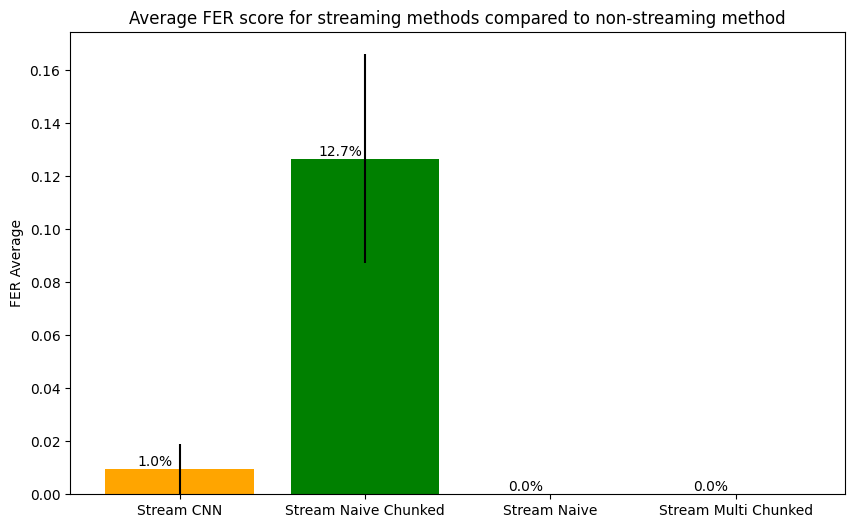

In [7]:
def capitalize(text: str):
    return " ".join(t.capitalize() for t in text.split("_")).replace("Cnn", "CNN")

plt.figure(figsize=(10, 6))
bars = plt.bar(
    [capitalize(m.__name__).replace(" Chunked Transformer", "") for m in methods],
    [results[f"{m.__name__}_fer"].mean() for m in methods],
    yerr=[min(results[f"{m.__name__}_fer"].std(), results[f"{m.__name__}_fer"].mean()) for m in methods],
    color=COLORS,
)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 3, height, f'{100 * height:0.1f}%', 
             ha='center', va='bottom')
plt.ylabel("FER Average")
plt.title("Average FER score for streaming methods compared to non-streaming method")
plt.show()

The chunked CNN method is almost as accurate as the naive streaming method (13x lower FER compared to naive chunking) but still retains 1% FER since the online normalization is not a perfect approximation of global normalization. The tradeoff between accuracy loss and latency can be adjusted by increasing the initial waiting latency (to accumulate more data for better normalization stats). I found that just doing the normal chunk size for warmup is the sweet spot (improves FER from 1.1% to 1.0%) and gains after that are marginal. We will have to see if this changes when we add VAD and LLM sliding window (e.g. with local agreement policy or attention heuristics).

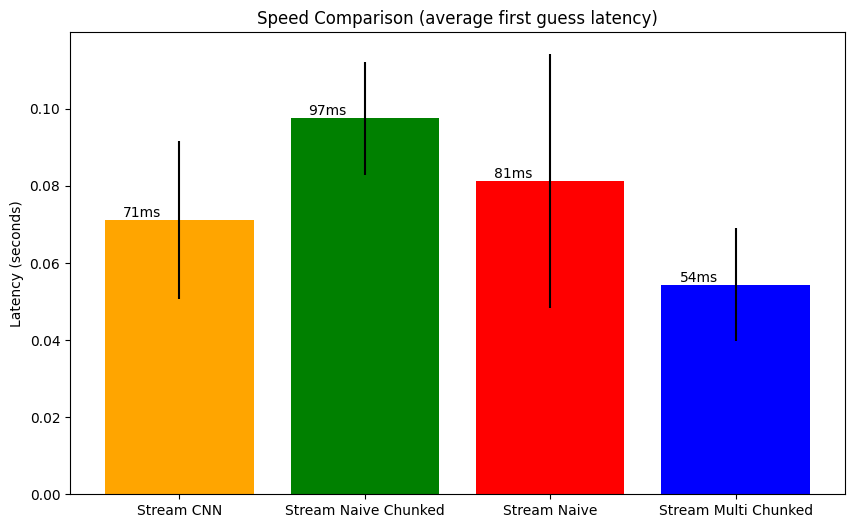

In [8]:
labels = [capitalize(m.__name__).replace(" Chunked Transformer", "") for m in methods]
latencies = [results[f"{m.__name__}_average_first_guess_latency"].mean() for m in methods]
latencies_std = [min(results[f"{m.__name__}_average_first_guess_latency"].std(), results[f"{m.__name__}_average_first_guess_latency"].mean()) for m in methods]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, latencies, yerr=latencies_std, color=COLORS)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 4, height, f'{int(1000 * height)}ms', 
             ha='center', va='bottom')
plt.ylabel('Latency (seconds)')
plt.title('Speed Comparison (average first guess latency)')
plt.show()

As expected, the CNN chunking (yellow) does outperform the naive streaming (red) in terms of first guess latency (when a phoneme is first predicted for a chunk of audio, even if it is later corrected). Interestingly, the naive chunking approach (green) is slower in this metric. This is both because my device is fast enough to take advantage of a smaller accumulation size than the chunk size the naive method is using and because its chunk size is set high in the first place to reduce accuracy loss (if you look at the computation time metrics, the naive chunking uses a small fraction of the available compute time whereas the adaptive chunk size of the other two methods uses almost all of it). This is also reflected later in the delay plot.

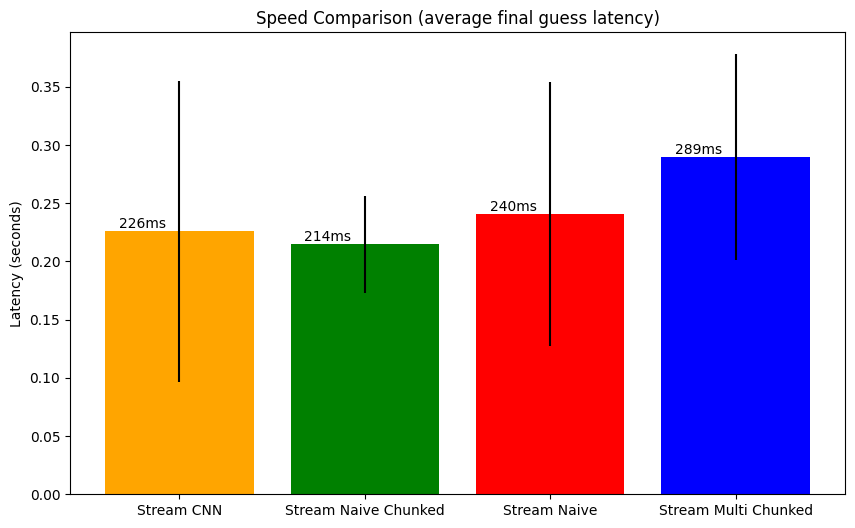

In [9]:
labels = [capitalize(m.__name__).replace(" Chunked Transformer", "") for m in methods]
latencies = [results[f"{m.__name__}_average_final_guess_latency"].mean() for m in methods]
latencies_std = [min(results[f"{m.__name__}_average_final_guess_latency"].std(), results[f"{m.__name__}_average_final_guess_latency"].mean()) for m in methods]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, latencies, yerr=latencies_std, color=COLORS)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 4, height, f'{int(1000 * height)}ms', 
             ha='center', va='bottom')
plt.ylabel('Latency (seconds)')
plt.title('Speed Comparison (average final guess latency)')
plt.show()

As expected, the naive chunking method is faster than the CNN chunking method which is faster than the naive streaming method for final guess latency (when a phoneme is predicted and not changed later). Note that using online normalization while not that significant for accuracy, does improve final latency significantly for the chunking methods because chunk-wise normalization is less stable and leads to more corrections later on.

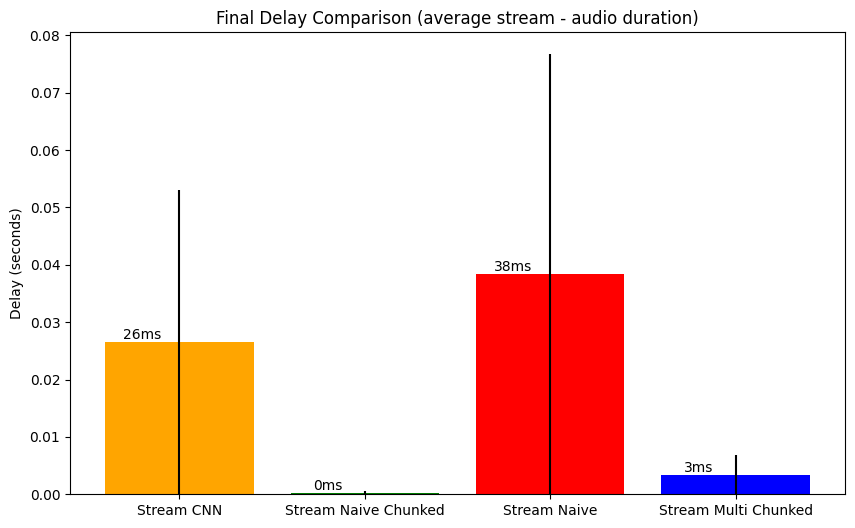

In [10]:
labels = [capitalize(m.__name__).replace(" Chunked Transformer", "") for m in methods]
delays = [(results[f"{m.__name__}_stream_duration"] - results[f"{m.__name__}_audio_duration"]).mean() for m in methods]
delays_std = [min((results[f"{m.__name__}_stream_duration"] - results[f"{m.__name__}_audio_duration"]).std(), (results[f"{m.__name__}_stream_duration"] - results[f"{m.__name__}_audio_duration"]).mean()) for m in methods]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, delays, yerr=delays_std, color=COLORS)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 4, height, f'{int(1000 * height)}ms', 
             ha='center', va='bottom')
plt.ylabel('Delay (seconds)')
plt.title('Final Delay Comparison (average stream - audio duration)')
plt.show()

The naive chunking method utilizes very little compute time, so it can return the final transcription almost immediately after the audio stream ends. The other streaming methods use almost all the compute time to provide accurate yet low latency transcriptions, so they have a small delay after the audio stream ends. The CNN chunking method is slightly faster than the naive streaming method, as expected, since it has to do less work. Conveniently, the speedup (15ms/44ms) is about the same as the theoretical work reduction (CNN is 33% of macc operations). This also holds in the previous latency graph if the base latency is subtracted out.

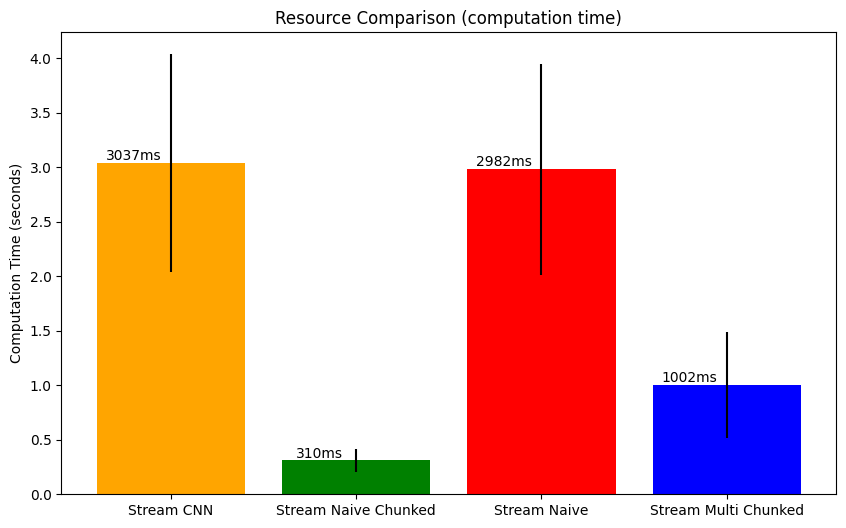

In [14]:
labels = [capitalize(m.__name__).replace(" Chunked Transformer", "") for m in methods]
latencies = [results[f"{m.__name__}_computation_time"].mean() for m in methods]
latencies_std = [min(results[f"{m.__name__}_computation_time"].std(), results[f"{m.__name__}_computation_time"].mean()) for m in methods]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, latencies, yerr=latencies_std, color=COLORS)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 4, height, f'{int(1000 * height)}ms', 
             ha='center', va='bottom')
plt.ylabel('Computation Time (seconds)')
plt.title('Resource Comparison (computation time)')
plt.show()

Computation time is not the most important metric since we can always just scale up the amount of compute to keep up with more users. However all else being equal, we still want it as low as possible so we can serve more users with the same amount of compute. Naturally, the chunking methods use less compute time while the other methods consume as much compute as possible to reduce latency. That is the nature of the tradeoff between latency, accuracy, and computational resources.

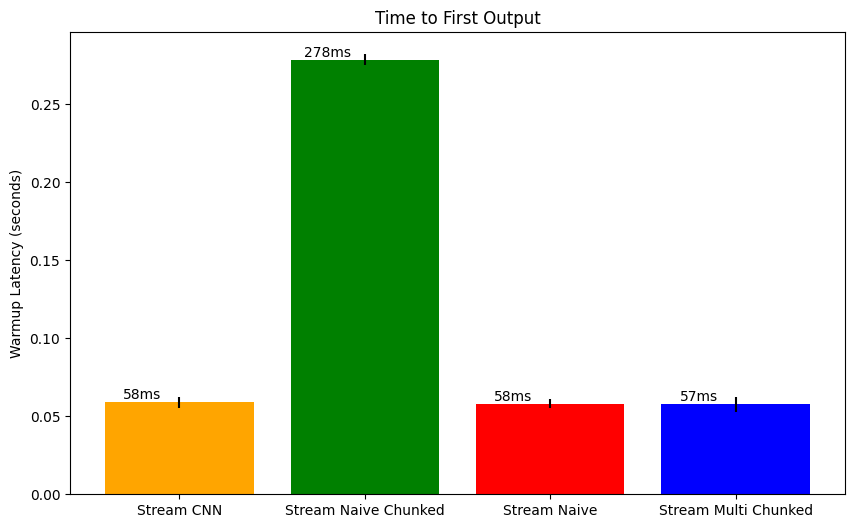

In [15]:
labels = [capitalize(m.__name__).replace(" Chunked Transformer", "") for m in methods]
latencies = [results[f"{m.__name__}_warmup_latency"].mean() for m in methods]
latencies_std = [min(results[f"{m.__name__}_warmup_latency"].std(), results[f"{m.__name__}_warmup_latency"].mean()) for m in methods]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, latencies, yerr=latencies_std, color=COLORS)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 4, height, f'{int(1000 * height)}ms', 
             ha='center', va='bottom')
plt.ylabel('Warmup Latency (seconds)')
plt.title('Time to First Output')
plt.show()

As mentioned for the first guess latency, the naive chunking method has the chunk size set high to reduce accuracy loss. This introduces quite a bit of warmup latency (delay between when the user starts speaking and the first phoneme is predicted). This is not the most important metric since it only impacts the beginning, however the beginning is quite important for user experience. It not only lets the user know that the system is working and can hear them but, since the speech snippets are quite short, it can also mean the system is irresponsive for a large fraction of the snippet.

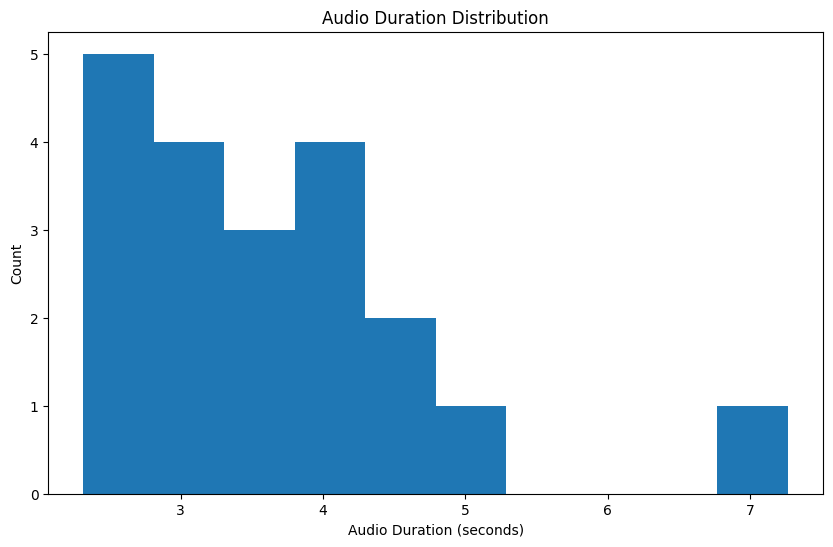

3668 ± 1151.489648658788 ms


In [24]:
m = methods[0]
durations = results[f"{m.__name__}_audio_duration"]
latencies_std = [min(results[f"{m.__name__}_audio_duration"].std(), results[f"{m.__name__}_audio_duration"].mean()) for m in methods]

plt.figure(figsize=(10, 6))
plt.hist(durations)
plt.xlabel('Audio Duration (seconds)')
plt.ylabel('Count')
plt.title('Audio Duration Distribution')
plt.show()
print(f"{int(durations.mean()*1000)} ± {(durations*1000).std()} ms")

This gives a sense for the variability in audio duration. We expect the variation in computation time to be similar. However, the variation in latency should ideally be much lower since we want to provide a consistent user experience that works for both short and long utterances. The naive chunking method has the lowest variance since it operates on fixed size chunks.